Project 1

Sabrina Pereira

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

How has the opioid epidemic affected the life expectancy in the US? 

First, let us load the data. I will also add the life expectancies the CDC has released in recent years that were not included in the dataset. These can be found at the following links:

Mortality in the United States, 2015: https://www.cdc.gov/nchs/products/databriefs/db267.htm

Mortality in the United States, 2016: https://www.cdc.gov/nchs/products/databriefs/db293.htm

Mortality in the United States, 2017: https://www.cdc.gov/nchs/products/databriefs/db328.htm

In [2]:
nchs = pd.read_csv('nchs.csv', sep=',')
opioid = pd.read_csv('Opiod Related Deaths, 1999-2017.txt', sep='\t')
mortality = pd.read_csv('All Deaths, 1999-2017.txt', sep='\t')

#Extract total deaths
opioid_totals = opioid[(opioid.Notes == 'Total') & (opioid.Year.notna())].reset_index(drop=True)
mortality_totals = mortality[(mortality.Notes == 'Total') & (mortality.Year.notna())].reset_index(drop=True)

#Clean data to only contain rows that have valid years
opioid = opioid[(opioid.Year.notna()) & (opioid['Ten-Year Age Groups Code'] != 'NS') & (opioid.Notes.isna())]
mortality = mortality[(mortality.Year.notna()) & (mortality['Ten-Year Age Groups Code'] != 'NS') & (mortality.Notes.isna())]


d = {'Year': [2017, 2016, 2015], 'Race': 3*['All Races'], 'Sex' : 3*['Both Sexes'], 'Average Life Expectancy (Years)':[78.6,78.7, 78.7], 'Age-adjusted Death Rate': [731.9, 728.8, 733.1]}
df = pd.DataFrame(data=d)

#Adding the nchs data to a data frame with the most recent data 
nchs = df.append(nchs.drop([0]), ignore_index=True)

In [3]:
nchs.head()

,Year,Race,Sex,Average Life Expectancy (Years),Age-adjusted Death Rate
0,2017,All Races,Both Sexes,78.6,731.9
1,2016,All Races,Both Sexes,78.7,728.8
2,2015,All Races,Both Sexes,78.7,733.1
3,2014,All Races,Both Sexes,78.9,724.6
4,2013,All Races,Both Sexes,78.8,731.9


We are interested in the population as a whole, so we will take only the parts of the NCHS data that describe everyone.  

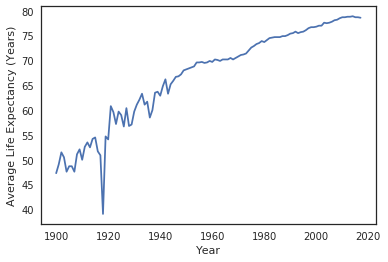

In [4]:
everyone = nchs[(nchs.Race == 'All Races') & (nchs.Sex == 'Both Sexes')]

plt.plot(everyone.Year, everyone['Average Life Expectancy (Years)'])

plt.xlabel('Year')
plt.ylabel('Average Life Expectancy (Years)');

We are only interested in the data of recent years, so we will put the data from 1999-2017 in a new data frame to align with our mortality data. We will also make sure that this data frame has the years in acscending order to match the mortality data.

In [5]:
recent = everyone[everyone.Year > 1998][::-1].reset_index(drop=True)
recent.head()

,Year,Race,Sex,Average Life Expectancy (Years),Age-adjusted Death Rate
0,1999,All Races,Both Sexes,76.7,875.6
1,2000,All Races,Both Sexes,76.8,869.0
2,2001,All Races,Both Sexes,77.0,858.8
3,2002,All Races,Both Sexes,77.0,855.9
4,2003,All Races,Both Sexes,77.6,843.5


Let's take a closer look at how life expectancy in the US has changed in the recent years.

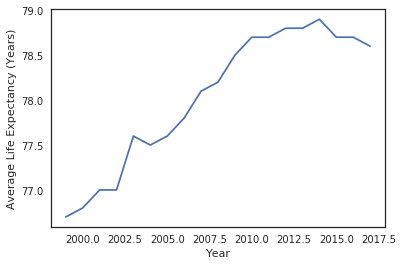

In [6]:
plt.plot(recent.Year, recent['Average Life Expectancy (Years)'])
plt.xlabel('Year')
plt.ylabel('Average Life Expectancy (Years)');

Lets take a look at how opiod overdose related deaths have changed over the same interval. In order to adjust for population, we will use the crude rate instead of number of deaths - this indicates deaths per 100,000 people.

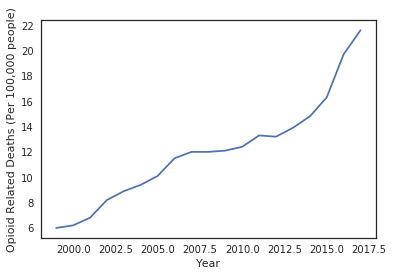

In [7]:
plt.plot(opioid_totals.Year, opioid_totals['Crude Rate'].astype('float64'))
plt.xlabel('Year')
plt.ylabel('Opioid Related Deaths (Per 100,000 people)');

It seems that around 2015, at the same time we start noticing that the number of opiod overdose releated deaths starts dramatically increasing, the life expectancy starts to drop.

If the increase in opiod related deaths has impacted the life expectancy negatively, we would expect to see that there is a negative relationship between the two variables.

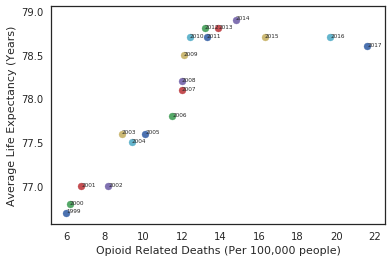

In [8]:
for i, txt in enumerate(recent.Year):
    plt.scatter(opioid_totals['Crude Rate'].astype('float64')[i],recent['Average Life Expectancy (Years)'][i])
    plt.annotate(txt, (opioid_totals['Crude Rate'].astype('float64')[i],recent['Average Life Expectancy (Years)'][i]), fontsize = 'xx-small')


plt.xlabel('Opioid Related Deaths (Per 100,000 people)')
plt.ylabel('Average Life Expectancy (Years)');



Unfortunately, there seems to be a very positive relationship between opioid related deaths and average life expectancy in the very beginning. The deaths related to opioid overdoses cannot be contriuting to this rising life expectancy - this is more likely due to other factors such as improvements in healthcare and sanitation. 

Recalcultating the theoretical life expectancies removing the effect of the opioid related deaths to observe how much of the drop in life expectancy is explained by the opiod related deaths would be ideal, but it was a bit out of scope for this project (could likely be done in a continuation of the project).

For simplifications, I will then be looking at how the Age-adjusted death rate would change, as I suspect that the variables are closely related.

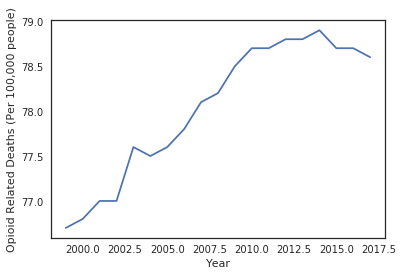

In [9]:
plt.plot(recent.Year, recent['Average Life Expectancy (Years)']);
plt.xlabel('Year')
plt.ylabel('Opioid Related Deaths (Per 100,000 people)');

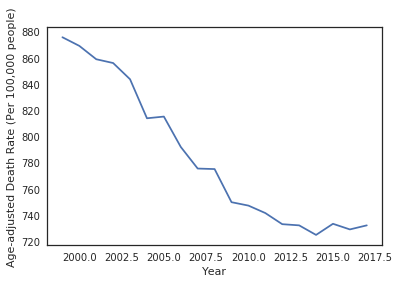

In [10]:
plt.plot(recent.Year, recent['Age-adjusted Death Rate']);
plt.xlabel('Year')
plt.ylabel('Age-adjusted Death Rate (Per 100,000 people)');

The two graphs seem quite similar, so I performed a linear regression to see how strong the correlation is between the two variables. The coefficient of determination is .97, indicating that by knowing what happens to the age-adjusted death rate we know much about what is going on with the average life expectancy.

0.9742939852917004


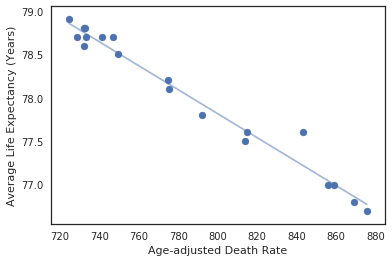

In [11]:
from scipy.stats import linregress

xs = recent['Age-adjusted Death Rate']
ys = recent['Average Life Expectancy (Years)']

res = linregress(xs, ys)

fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-', alpha=0.5)



plt.scatter(recent['Age-adjusted Death Rate'], recent['Average Life Expectancy (Years)']);
plt.xlabel('Age-adjusted Death Rate')
plt.ylabel('Average Life Expectancy (Years)')
print(res.rvalue**2)

Since we have the data for the total population and number of deathf for each year, it should be simple to calculate the Death Rates for each year.

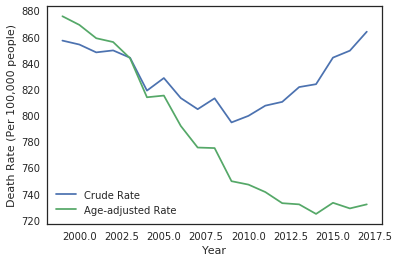

In [12]:
plt.plot(mortality_totals.Year, mortality_totals['Crude Rate'].astype('float64'), label='Crude Rate')
plt.plot(recent.Year, recent['Age-adjusted Death Rate'], label='Age-adjusted Rate');

plt.xlabel('Year')
plt.ylabel('Death Rate (Per 100,000 people)')
plt.legend();

This graph looks very different from the Age-Adjusted Death Rates graph we got using the NCHS data - this is because we need to take into account that some years will have more people in an age group that are likely to die, driving the death rates up (for example, a larger older population). 

To calculate the Age-Adjusted Death Rates with our data, we need to identify a "Standard Population". Age-adjusted rates are the Death Rates that you would observe if the the population in a different year had the same population distribution as the Standard Population. 

The National Center for Health Statistics uses the year 2000 for the Standard Population, so it is what I will be using as well.

Below is a function I will be using to generate the appropriate proportion of the population for each age group using the U.S. 2000 population distribution.

In [13]:
def age_group_pop_prop(row, year, df, df_totals):
    """    
    Takes in a row from a DataFrame, the desired year for the Standard Population,
    the DataFrame you would like to pull the total Standard Population from, and the 
    DataFrame that contains the Standard Population's proportions of deaths divided by 
    Ten-Year Age Groups Codes.
    
    Reads the Ten-Year Age Groups Code from the row, and returns the correct Standard Proportion.
    
    """  
    adjustment_mapping = {}
    standard_pop = float(df_totals[(df_totals.Year == year)].Population)

    for i, rows in df[df.Year == year].iterrows():
        adjustment_mapping[rows['Ten-Year Age Groups Code']] = float(rows['Population'])/standard_pop
    return adjustment_mapping.get(row['Ten-Year Age Groups Code'])

I will be adding a column for the Standard Proportion to the mortality DataFrame in order to use it to later find the Age-Adjusted Death Rates.

In [14]:
mortality['Standard Proportion'] =  mortality.apply(lambda row: age_group_pop_prop(row, 2000, mortality, mortality_totals), axis=1)
mortality.head()

,Notes,Year,Year Code,Ten-Year Age Groups,Ten-Year Age Groups Code,Deaths,Population,Crude Rate,Standard Proportion
0,NaN,1999.0,1999.0,< 1 year,1,27937.0,3795762,736.0,0.013523
1,NaN,1999.0,1999.0,1-4 years,1-4,5249.0,15339782,34.2,0.054616
2,NaN,1999.0,1999.0,5-14 years,5-14,7595.0,40819824,18.6,0.145964
3,NaN,1999.0,1999.0,15-24 years,15-24,30656.0,38676031,79.3,0.139235
4,NaN,1999.0,1999.0,25-34 years,25-34,41066.0,40178406,102.2,0.141751


Using the Age-Adjusted Death Rate Definition from the Missouri Department of Health and Senior Services (https://health.mo.gov/data/mica/CDP_MICA/AARate.html), 

AADR = Summation of (ASDR X standard proportion) 
  
Where ASDR (Age-Specific Death Rate) = deaths in age group ÷ estimated population of that age group × 100,000, equivalent to the information held in the Crude Rate Column.

I will multiply the `Crude Rate` and the `Standard Proportion` columns in order to find the proportion of each Crude Rate to sum for the year's Age-Adjusted Death Rate.

In [15]:
mortality['CR*SP'] =  mortality['Crude Rate'].astype('float64')*mortality['Standard Proportion']
mortality.head()

,Notes,Year,Year Code,Ten-Year Age Groups,Ten-Year Age Groups Code,Deaths,Population,Crude Rate,Standard Proportion,CR*SP
0,NaN,1999.0,1999.0,< 1 year,1,27937.0,3795762,736.0,0.013523,9.952875
1,NaN,1999.0,1999.0,1-4 years,1-4,5249.0,15339782,34.2,0.054616,1.867869
2,NaN,1999.0,1999.0,5-14 years,5-14,7595.0,40819824,18.6,0.145964,2.714938
3,NaN,1999.0,1999.0,15-24 years,15-24,30656.0,38676031,79.3,0.139235,11.041367
4,NaN,1999.0,1999.0,25-34 years,25-34,41066.0,40178406,102.2,0.141751,14.486911


I will now add sum the values for each year's Age-Adjusted Death Rate, and add it as a column to `mortality_totals`. 

In [16]:
def calculate_AADR(row, df):
    """
    Takes in an input row from a DataFrame of totals.
    Returns the Age-Adjusted Death Rate.
    """
    year = row.Year
    AADR = df[df.Year == year]['CR*SP'].sum()
    
    return AADR
    
       
mortality_totals['Age-adjusted Death Rate'] = mortality_totals.apply(lambda row: calculate_AADR(row, mortality), axis=1)    
mortality_totals.head()


,Notes,Year,Year Code,Ten-Year Age Groups,Ten-Year Age Groups Code,Deaths,Population,Crude Rate,Age-adjusted Death Rate
0,Total,1999.0,1999.0,NaN,NaN,2391399.0,279040168,857.0,860.425108
1,Total,2000.0,2000.0,NaN,NaN,2403351.0,281421906,854.0,853.883170
2,Total,2001.0,2001.0,NaN,NaN,2416425.0,284968955,848.0,843.925198
3,Total,2002.0,2002.0,NaN,NaN,2443387.0,287625193,849.5,840.992571
4,Total,2003.0,2003.0,NaN,NaN,2448288.0,290107933,843.9,828.798343


My calculalted Age Adjusted Death Rates closely match the trend of those in the NCHS dataset. The difference may be due to slight differences in the population estimates or calculation.

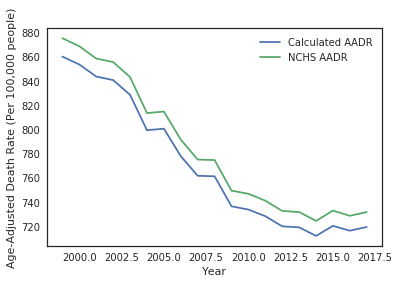

In [17]:
plt.plot(mortality_totals.Year, mortality_totals['Age-adjusted Death Rate'], label = 'Calculated AADR')
plt.plot(recent.Year, recent['Age-adjusted Death Rate'], label = 'NCHS AADR');

plt.xlabel('Year')
plt.ylabel('Age-Adjusted Death Rate (Per 100,000 people)');
plt.legend();

Since calculated AADR's are very close to the one's given in the NCHS data, I performed a linear regression to see if I am able to predict the Average Life Expecancy from the AADR. 

The coefficient of determination is again .97. I take this to mean that a very close estimation of the Life Expectancy if I have the AADR.

0.9746100048542374


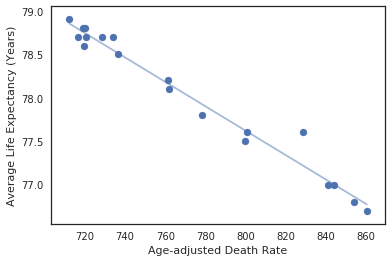

In [18]:
xs = mortality_totals['Age-adjusted Death Rate']
ys = recent['Average Life Expectancy (Years)']

res = linregress(xs, ys)

fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-', alpha=0.5)



plt.scatter(mortality_totals['Age-adjusted Death Rate'], recent['Average Life Expectancy (Years)']);
plt.xlabel('Age-adjusted Death Rate')
plt.ylabel('Average Life Expectancy (Years)')
print(res.rvalue**2)

Under this assumption, I will be finding the theoretical AADR's if there have been no deaths resulting from opioid overdoses. 

To do this, I will subtract the deaths counted in the `opioid` DataFrame to the `mortality` deaths in a new DataFrame, use this to calculate AADR's, and check to see 1) How large the difference is between the two cases for each year, and 2) How like.

I will make a copy of `mortality` and `mortality_totals`, and adjust them to not include the deaths related to opiod overdoses.

In [19]:
mortality_adjusted = mortality.copy().drop(['Standard Proportion','CR*SP'], axis=1)
mortality_adjusted_totals = mortality_totals.copy().drop(['Age-adjusted Death Rate'], axis=1)

#Remove the deaths 
mortality_adjusted.Deaths = mortality_adjusted.Deaths - opioid.Deaths
mortality_adjusted_totals.Deaths = mortality_adjusted_totals.Deaths - opioid_totals.Deaths

#In cases where the Crude Rate is very small it is termed "Unreliable", we will replace it with 0
opioid['Crude Rate'].replace('Unreliable',0, inplace=True)

#Remove the deaths contributing to the crude rate
mortality_adjusted['Crude Rate'] = mortality_adjusted['Crude Rate'].astype('Float64')-opioid['Crude Rate'].astype('Float64')
mortality_adjusted_totals['Crude Rate'] = mortality_adjusted_totals['Crude Rate'].astype('Float64')-opioid_totals['Crude Rate'].astype('Float64')



We will perform the same process as before to find the new Age-adjusted Death Rates.

In [20]:
#Creating Standard Proportion Column and the (Crude Rate * Standard Prop) column
mortality_adjusted['Standard Proportion'] =  mortality_adjusted.apply(lambda row: age_group_pop_prop(row, 2000, mortality_adjusted, mortality_adjusted_totals), axis=1)
mortality_adjusted['CR*SP'] =  mortality_adjusted['Crude Rate'].astype('float64')*mortality_adjusted['Standard Proportion']

#Finding the AADRs for the adjusted dataset
mortality_adjusted_totals['Age-adjusted Death Rate'] = mortality_adjusted_totals.apply(lambda row: calculate_AADR(row, mortality_adjusted), axis=1)    

I will plot the AADR's from `mortality` on the same plot as those from `mortality_adjusted`.

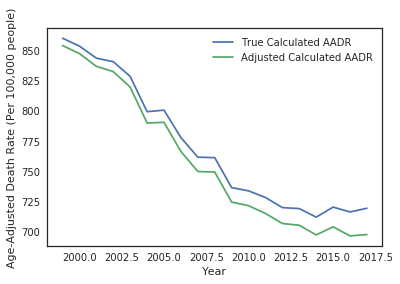

In [21]:
plt.plot(mortality_totals.Year, mortality_totals['Age-adjusted Death Rate'], label = 'True Calculated AADR')
plt.plot(mortality_adjusted_totals.Year, mortality_adjusted_totals['Age-adjusted Death Rate'], label = 'Adjusted Calculated AADR');

plt.xlabel('Year')
plt.ylabel('Age-Adjusted Death Rate (Per 100,000 people)');
plt.legend();

It looks like the effect of opiod related deaths on the AADR has increased over time, we can take a look at the difference between them.

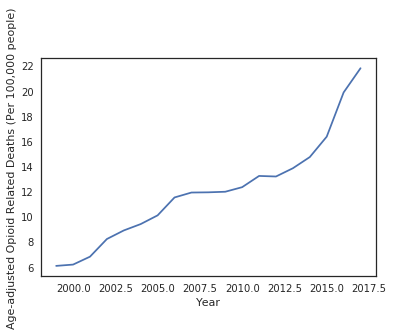

In [22]:
diff_in_AADR = mortality_totals['Age-adjusted Death Rate'] - mortality_adjusted_totals['Age-adjusted Death Rate']
plt.plot(mortality_totals.Year, diff_in_AADR)
plt.xlabel('Year')
plt.ylabel('Age-adjusted Opioid Related Deaths (Per 100,000 people)');

The Crude Death Rate and the Age-adjusted Death Rate of opioid related deaths look almost identical - something that we didn't see comparing the Crude Death Rate and the Age-adjusted Death Rate of the population's deaths. This indicates that that opioid related deaths have occured consistently in the same proportions across age groups.

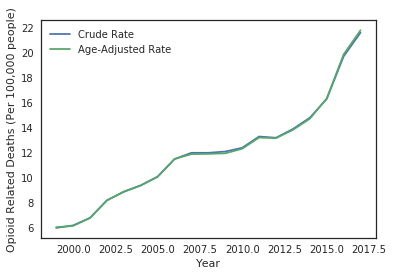

In [23]:
plt.plot(opioid_totals.Year, opioid_totals['Crude Rate'].astype('float64'), label='Crude Rate')
plt.plot(mortality_totals.Year, diff_in_AADR, label='Age-Adjusted Rate')
plt.xlabel('Year')
plt.ylabel('Opioid Related Deaths (Per 100,000 people)');
plt.legend();

I will now tranfer this information into terms of life expectancies. We can use the linear regression model I created to fit my data to see how well I can estimate life expectancy using the Age-adjusted Death Rate.

In [24]:
life_expect = recent[['Year','Average Life Expectancy (Years)']].join(mortality_totals['Age-adjusted Death Rate']).join(mortality_adjusted_totals['Age-adjusted Death Rate'], rsuffix=' -Opioid')

#Make a column with the life expectancy we would expect to see if the linear regression can be used to find
life_expect['ALE Expected by AADR'] = life_expect['Age-adjusted Death Rate']*res.slope + res.intercept
life_expect['Residuals'] = life_expect['Average Life Expectancy (Years)'] - life_expect['ALE Expected by AADR']

#Make a column with the life expectancy we would expect to see if there were no opiod related deaths
life_expect['ALE Expected by Adjusted AADR'] = life_expect['Age-adjusted Death Rate -Opioid']*res.slope + res.intercept
life_expect['Expected Loss in ALE'] = life_expect['Average Life Expectancy (Years)'] - life_expect['ALE Expected by Adjusted AADR']

life_expect

,Year,Average Life Expectancy (Years),Age-adjusted Death Rate,Age-adjusted Death Rate -Opioid,ALE Expected by AADR,Residuals,ALE Expected by Adjusted AADR,Expected Loss in ALE
0,1999,76.7,860.425108,854.367604,76.773313,-0.073313,76.858308,-0.158308
1,2000,76.8,853.883170,847.721682,76.865105,-0.065105,76.951559,-0.151559
2,2001,77.0,843.925198,837.134113,77.004828,-0.004828,77.100116,-0.100116
3,2002,77.0,840.992571,832.796599,77.045977,-0.045977,77.160977,-0.160977
4,2003,77.6,828.798343,819.919634,77.217078,0.382922,77.341658,0.258342
5,2004,77.5,799.576490,790.190896,77.627099,-0.127099,77.758791,-0.258791
6,2005,77.6,800.843609,790.764634,77.609320,-0.009320,77.750741,-0.150741
7,2006,77.8,778.123762,766.619773,77.928109,-0.128109,78.089525,-0.289525
8,2007,78.1,761.880091,749.984769,78.156029,-0.056029,78.322936,-0.222936
9,2008,78.2,761.482836,749.570799,78.161603,0.038397,78.328745,-0.128745


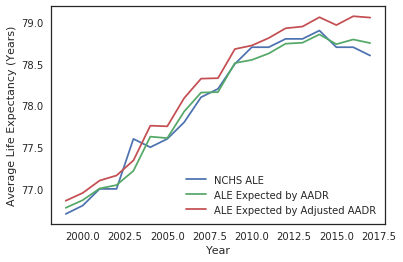

In [25]:
plt.plot(life_expect.Year, life_expect['Average Life Expectancy (Years)'], label='NCHS ALE')
plt.plot(life_expect.Year, life_expect['ALE Expected by AADR'], label='ALE Expected by AADR')
plt.plot(life_expect.Year, life_expect['ALE Expected by Adjusted AADR'], label='ALE Expected by Adjusted AADR')

plt.xlabel('Year')
plt.ylabel('Average Life Expectancy (Years)');
plt.legend();

In general, my function for estimating the Average Life Expectancy from the AADR is accurate to within .15 years (excluding the year 2003), so it is a decent estimator of the life expectancy we would expect to see if there were no contributing opioid related deaths. 

From this model, I would expect that the Average Life Expecatncy in 2017 would have been approximately 79.1 years if there had been no opioid related deaths, 0.45 years higher than the observed 78.6. 